In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '/home/lauraelina.uronen/silmarel/')

import numpy as np 

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

import silmarel
from silmarel.simulation.data_sim import ModelSim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of silmarel.simulation.data_sim failed: Traceback (most recent call last):
  File "/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/lauraelina.uronen/silmarel/silmarel/simulation/data_sim.py", line 12, in <module>
    from dataclass import dataclass
ModuleNotFoundError: No module named 'dataclass'
]


In [9]:
# lens characteristics
center_x, center_y = 0, 0
z_lens = 0.7
# source (EM) characteristics
source_x, source_y = 0.07, 0.03
z_source = 1.5

lens_model_list = ['EPL', 'SHEAR']
lens_light_model_list = ['SERSIC_ELLIPSE'] 
source_light_model_list = ['SERSIC_ELLIPSE']

kwargs_epl = {'theta_E': 1.0, 
                'center_x': center_x, 
                'center_y': center_y, 
                'e1': 0.1, 
                'e2': 0., 
                'gamma': 2}
kwargs_shear = {'gamma1': 0.1, 
                'gamma2': 0.2}
kwargs_lens = [kwargs_epl, kwargs_shear]

# lens light
kwargs_lens_light_mag = [{'amp': 50, 
                          'R_sersic': .2, 
                          'n_sersic': 4, 
                          'e1': 0.1, 
                          'e2': 0., 
                          'center_x': center_x, 
                          'center_y': center_y}]
# source light
kwargs_source_mag = [{'amp': 100, 
                      'R_sersic': 0.05, 
                      'n_sersic': 1, 
                      'e1': -0.3, 
                      'e2': -0.2, 
                      'center_x': source_x, 
                      'center_y': source_y}]

lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_source, z_lens=z_lens)
lensLightModel = LightModel(light_model_list=lens_light_model_list)
sourceLightModel = LightModel(light_model_list=source_light_model_list)

In [12]:
numPix = 60
deltaPix = 0.067 
shift = numPix * deltaPix / 2
ra_start, dec_start = center_x - shift, center_y - shift
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix

fwhm = 0.067 #HST/JWST: 0.067, TMT/ELT: 0.01 in IR

background_rms = None
exposure_time = 2200

kwargs_pixel = {'nx': numPix, 'ny': numPix, 'ra_at_xy_0': ra_start, 'dec_at_xy_0': dec_start, 'transform_pix2angle': transform_pix2angle}
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
kwargs_data = {'image_data': None, 'background_rms': background_rms, 'exposure_time': exposure_time, 'ra_at_xy_0': ra_start, 'dec_at_xy_0': dec_start, 'transform_pix2angle': transform_pix2angle}

models = [lensModel, sourceLightModel, lensLightModel]
kwargs_models = [kwargs_lens, kwargs_source_mag, kwargs_lens_light_mag]
kwargs_settings = [kwargs_data, kwargs_psf, kwargs_pixel, kwargs_numerics]

In [ ]:
model = ModelSim(models, kwargs_models, kwargs_settings)

TypeError: ModelSim.__init__() missing 5 required positional arguments: 'source_kwargs', 'kwargs_data', 'kwargs_psf', 'kwargs_pixel', and 'kwargs_numerics'

/local/lauraelina.uronen/ipykernel_2147597/2814578255.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(model.data))


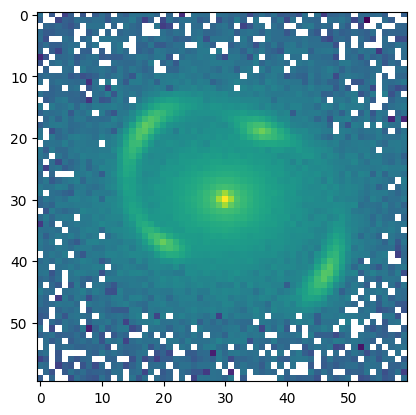

In [7]:
import matplotlib.pyplot as plt 

plt.imshow(np.log10(model.data))